In [3]:
from sklearn.pipeline import make_pipeline
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import spacy
# Create CV training and test scores for various training set sizes
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

nlp = spacy.load("en_core_web_sm")


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 10), scoring='f1_macro'):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,
        scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt



def tf_idf(df_data, vectorizer):
    X_train, X_test, y_train, y_test = train_test_split(df_data['sentence'], df_data['label'], test_size=0.2,
                                                        random_state=42)
    features_train_transformed = vectorizer.fit_transform(X_train)  # gives tf idf vector for x_train
    features_test_transformed = vectorizer.transform(X_test)  # gives tf idf vector for x_test

    return features_train_transformed, features_test_transformed, y_train, y_test


def text_to_df(data_path="SMSSpamCollection.txt"):
    print("morph data into a dataframe")
    with open(data_path, "r") as f:
        input_text = f.readlines()

    input_text = [(i.split("\t")[0], i.split("\t")[-1]) for i in input_text]
    df_data = pd.DataFrame(input_text, columns=["label", "sentence"])
    print("all data", df_data.shape)
    print("spam count", df_data.loc[df_data["label"] == "spam", :].shape[0])
    print("ham count", df_data.loc[df_data["label"] == "ham", :].shape[0])
    df_data["label"] = df_data["label"].apply(lambda x: 1 if x == "spam" else 0)
    return df_data


def cleanup(sentence, del_digits=False, del_punct=False, del_urls_emails=False, del_space=True,
            del_stop=True, del_symbols=False, lemma=True):
    tokens = []
    for token in nlp(sentence):
        if token.is_digit and del_digits:
            continue
        elif token.is_punct and del_punct:
            continue
        elif token.like_url or token.like_email and del_urls_emails:
            continue
        elif token.is_stop and del_stop:
            continue
        elif token.is_space and del_space:
            continue
        elif token.pos_ in {'SYM', 'X'} and del_symbols:
            continue
        else:
            tokens.append(token.lemma_ if lemma else token.text)
    return tokens


def get_results(ftt, f_test_t, y_tn, y_ts, classifier):
    print("value")
    # train the model
    classifier.fit(ftt, y_tn)
    print("classifier accuracy {:.2f}%".format(classifier.score(f_test_t, y_ts) * 100))

    labels = classifier.predict(f_test_t)
    actual = y_ts.tolist()
    predicted = labels
    results = confusion_matrix(actual, predicted)
    print('Confusion Matrix :')
    print(results)
    print('Accuracy Score :', accuracy_score(actual, predicted))
    print('Report : ')
    print(classification_report(actual, predicted))
    score_2 = f1_score(actual, predicted, average='binary')
    print('F-Measure: %.3f' % score_2)
    return classifier


morph data into a dataframe
all data (5574, 2)
spam count 747
ham count 4827
cross validating model
[0.96393972 0.96071044 0.96555436]
0.9634015069967706
value
classifier accuracy 96.68%
Confusion Matrix :
[[952   2]
 [ 35 126]]
Accuracy Score : 0.9668161434977578
Report : 
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       954
           1       0.98      0.78      0.87       161

    accuracy                           0.97      1115
   macro avg       0.97      0.89      0.93      1115
weighted avg       0.97      0.97      0.97      1115

F-Measure: 0.872
plotting curves


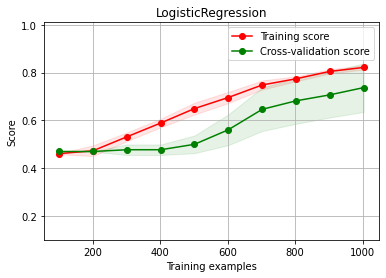

cross validating model
[0.95801938 0.95748116 0.95532831]
0.9569429494079656
value
classifier accuracy 96.68%
Confusion Matrix :
[[954   0]
 [ 37 124]]
Accuracy Score : 0.9668161434977578
Report : 
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       954
           1       1.00      0.77      0.87       161

    accuracy                           0.97      1115
   macro avg       0.98      0.89      0.93      1115
weighted avg       0.97      0.97      0.96      1115

F-Measure: 0.870
plotting curves


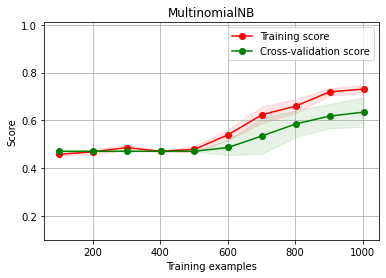

cross validating model
[0.98277718 0.9752422  0.98223897]
0.9800861141011841


In [ ]:
df_data = text_to_df()

vectorizer = TfidfVectorizer(tokenizer=cleanup, lowercase=True)

models = [LogisticRegression, MultinomialNB, SVC]

for model in models:
    print("cross validating model")
    clf = make_pipeline(vectorizer, model())
    scores = cross_validate(clf, df_data["sentence"], df_data["label"], cv=3, return_train_score=False)
    print(scores["test_score"])
    print(scores["test_score"].mean())
    features_train_transformed, features_test_transformed, y_train, y_test = tf_idf(df_data, vectorizer)

    model = get_results(features_train_transformed, features_test_transformed, y_train, y_test, model())
    print("plotting curves")
    
    
    plotter = plot_learning_curve(model, "%s"%type(model).__name__, features_test_transformed, model.predict(features_test_transformed), (0.1, 1.01), cv=10, n_jobs=-1)
    plotter.show()

In [ ]:
df_data.loc[y_test.loc[y_test==1].index,"sentence"].to_list()[:5]

In [ ]:
model.predict(vectorizer.transform(df_data.loc[y_test.loc[y_test==1].index,"sentence"].to_list()[:5]))

In [ ]:
df_data.loc[y_test.loc[y_test==1].index,"sentence"].to_list()[:5]

In [ ]:
model.predict(vectorizer.transform(df_data.loc[df_data["label"]==0,"sentence"].to_list()[:5]))